## Import các thư viện cần thiết

In [38]:
import re #regex
import csv
import os
import json
import pandas as pd
from pandas import DataFrame
import urllib.request
import joblib #load, dump pkl
from underthesea import word_tokenize #word_tokenize of lines
import numpy as np
import matplotlib.pyplot as plt
import transformers as ppb # load model BERT
from transformers import BertModel, BertTokenizer
import torch
from sklearn.model_selection import train_test_split

# 1. Data Visualization

## Load data

In [2]:
file = 'tiki_comments.csv'
df = pd.read_csv(file,sep=",")

(1399, 2)


### Kích thước của bộ dữ liệu

Dữ liệu có 1399 dòng và 2 cột.

In [15]:
df.shape

(1399, 2)

### Ý nghĩa các các cột

Kiểu dữ liệu của các cột

In [29]:
dtypes = df.dtypes
dtypes

comment     object
is_trust     int64
dtype: object

- Cột comment dạng chuỗi là bình luận của người dùng.
- Cột is_trust đánh giá bình luận là tích cực (1) hay tiêu cực (0). 

In [17]:
pd.set_option('display.max_colwidth',1000)
df.head(10)

,comment,is_trust
0,"Cực kì hài lòng, đẹp",1
1,"Cực kì hài lòng, ok ok",1
2,"Cực kì hài lòng, đẹp đấy",1
3,"Cực kì hài lòng,",1
4,"Cực kì hài lòng,",1
5,"Cực kì hài lòng,",1
6,"Cực kì hài lòng,",1
7,"Cực kì hài lòng,",1
8,"Cực kì hài lòng, Hat chia rất đều đep, date sd còn xa, tiki đóng goi cẩn thận , shipe giao hàng nhiet tinh, mong tiki giu uy tin voi khach hàng để phat triển tot hon, nhung nha ban hàng k có tam de nghi tiki loai ra khoi k để mất uy tín",1
9,"Mua Sắm ở Tiki, Sản phẩm ok, đóng gói kỹ\nMình dùng hạt chia kết hợp với Nước Rau củ; Thảo dược; Sữa chua cùng Trái cây; ...\nMỗi ngày 2 muỗng cafe thôi, mà cả tháng gần nửa túi, sắp phải mua thêm ;)))",1


## Chuẩn hoá dữ liệu

### Xoá các dòng có giá trị cột comment trùng lặp.

In [23]:
# Đếm số lượng dòng trùng lặp
num_duplicated_rows = df.duplicated(['comment']).sum()
num_duplicated_rows
# Xoá các dòng trùng
df.drop_duplicates(subset ="comment", keep = 'first', inplace = True) 

print(df.shape)
df.head(10)

(1158, 2)


,comment,is_trust
0,"Cực kì hài lòng, đẹp",1
1,"Cực kì hài lòng, ok ok",1
2,"Cực kì hài lòng, đẹp đấy",1
3,"Cực kì hài lòng,",1
8,"Cực kì hài lòng, Hat chia rất đều đep, date sd còn xa, tiki đóng goi cẩn thận , shipe giao hàng nhiet tinh, mong tiki giu uy tin voi khach hàng để phat triển tot hon, nhung nha ban hàng k có tam de nghi tiki loai ra khoi k để mất uy tín",1
9,"Mua Sắm ở Tiki, Sản phẩm ok, đóng gói kỹ\nMình dùng hạt chia kết hợp với Nước Rau củ; Thảo dược; Sữa chua cùng Trái cây; ...\nMỗi ngày 2 muỗng cafe thôi, mà cả tháng gần nửa túi, sắp phải mua thêm ;)))",1
10,"Chất lượng va rẻ, Hat to, no đều đẹp,ko bi von cục. Đúng la chất lượng hơn chỗ khac",1
11,"Cực kì hài lòng, Túi rất to, hạt chia đẹp, to đều, không hề thấy sạn hay cỏ rác như các loại đã mua trước đây. Vô cùng hài lòng với sản phẩm này.",1
12,"Cực kì hài lòng, Lúc mua mình không biết có phải loại dởm không vì rẻ như vậy. Tuy nhiên nhận hàng thấy chắc chắn, đáng tin, còn được tặng kèm nho khô nữa ạ!",1
13,"Hàng như hình, Hàng đúng mô tả, hạt to không lẫn sạn. Mình dùng không thường xuyên nên mấy tháng rồi chưa hết nửa kg, mua cho cả gia đình dùng thì ok.",1


### Chuẩn hoá comment
Dữ liệu hiện đang chứa những kí tự như dấu chấm câu, kí tự đặc biệt, icon,... Những kí tự này không cần thiết cho việc khai phá dữ liệu nên ta sẽ tiến hành loại bỏ chúng. Các bước loại bỏ:
- Xoá đi các dấu chấm câu như (. , ? ; ...)
- Xoá đi các kí tự đặc biệt: @,#,*,...
- Xoá khoảng trắng đầu và cuối mỗi comment, xoá  khoảng trắng dư thừa giữa các từ.
- Xoá đi icons và emoji.

In [4]:
def standardize_data(row):
    row = re.sub(r"[\.,\?]+$-", "", row)
    row = re.sub(r'[^\w]',' ', row) 
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")
    row = row.strip()
    row = " ".join(row.split())
    return row

Comment trước khi chuẩn hoá

In [26]:
df[20:30]

,comment,is_trust
24,"Cực kì hài lòng, Đèn ok!!! đẹp. ko bị trầy. gói cẩn thận. hợp với bàn nhỏ. Thích nhất là chân đèn. rất tiết kiệm diện tích. thiết kế thông minh!!. Còn có bóng đèn hay ko. ko quan trọng. có3 chế độ sáng tùy người thích ánh sáng vàng hay trắng.. khỏi phí. đáng đồng tiền. bàn to thì nên mua đèn mắc hơn.",1
25,"Cực kì hài lòng, Đèn đẹp, chắc chắn, đế nặng. Cổ đèn ko giống hình quảng cáo nhưng mình lại thích cổ đèn như này hơn. Nhìn xinh, Mỗi tội mua đèn nhưng ko có kèm bóng đèn phải mua ngoài. Mình xem có shop họ đóng trong hộp xốp như hộp đóng bộ ấm chén thì có đèn kèm theo. Ở đây chỉ thấy đóng trong thùng carton đế được bọc trong miếng bìa carton nữa. Ngoài thùng quấn nilon cùng xốp 2 mặt rất chắc chắn. Dù sao với cung cách gói sp và shipper nhiệt tình thì cho Tiki 5*.",1
26,"ngon bổ rẻ, đèn sáng đủ 3 chế độ sáng thường, vàng ấm và siêu sáng. Riêng màu vàng ấm tối bật lên làm đèn ngủ luôn, siêu ấm cúng. Cảm ứng siêu nhạy chạm dô cái sáng chưa tới 3 giây. Thích hơn nữa là có chỗ đựng bút nho nhỏ xinh xinh. Túm lại với giá tiền như vậy mà đc như thế là OK lắm đó cả nhà. À quên ai làm youtuber quất luôn em này về làm đèn chiếu trước camera 😆",1
27,"Hài Lòng, Mình đã sử dụng khoảng 1 tháng rồi, giờ mới quay lại đánh giá... Sản phẩm cực kì tốt với giá tiền, với 3 màu sắc khác nhau giúp ta linh hoạt được trong việc học cũng như các việc khác. Thiết kế nhỉ gọn, xinh xắn, đáng yêu. Màu sắc sản phẩm trang nhã. Đèn khi đầy pin phát sáng được từ 3 đến 4 tiếng và đến giờ vẫn chưa có hiện tượng chay pin. Rất ưng ý và hài lòng.",1
28,"Không hài lòng, Sản phẩm lỗi, 1/3 màu đèn không đủ sáng mà chỉ lên lờ mờ ngay khi vừa nhận sản phẩm. Mong muốn đổi lại hoặc trả hàng mua sản phẩm khác vì chất lượng không như mong muốn",0
29,"Cực kì hài lòng, Mình mua 11.11, sale còn 143k, quá rẻ lun. Sữa tắm thơm, nhiều bọt, dùng 1 lượng ít hơn sản phẩm khác. Giao hành nhanh, 5 sao.",1
30,"Hàng cao cấp, Hàng cao cấp, thơm ngào ngạt luôn á, mua đc tặng xà bông + giá sale nữa, quá thích.",1
31,"Cực kì hài lòng, Đóng gói quá chuẩn,hàng thì ok. Anh giao hàng quá dễ thương. Cám ơn tiki",1
32,"Cực kì hài lòng, giao hàng cực nhanh, đóng gói đẹp, sản phẩm như mô tả",1
33,"Cực kì hài lòng, Giao hàng nhanh, shipper lại dễ thương nữa 😊😊",1


### Sau khi chuẩn hoá

In [28]:
df['comment'] = df['comment'].apply(standardize_data)
df[20:30]

,comment,is_trust
24,Cực kì hài lòng Đèn ok đẹp ko bị trầy gói cẩn thận hợp với bàn nhỏ Thích nhất là chân đèn rất tiết kiệm diện tích thiết kế thông minh Còn có bóng đèn hay ko ko quan trọng có3 chế độ sáng tùy người thích ánh sáng vàng hay trắng khỏi phí đáng đồng tiền bàn to thì nên mua đèn mắc hơn,1
25,Cực kì hài lòng Đèn đẹp chắc chắn đế nặng Cổ đèn ko giống hình quảng cáo nhưng mình lại thích cổ đèn như này hơn Nhìn xinh Mỗi tội mua đèn nhưng ko có kèm bóng đèn phải mua ngoài Mình xem có shop họ đóng trong hộp xốp như hộp đóng bộ ấm chén thì có đèn kèm theo Ở đây chỉ thấy đóng trong thùng carton đế được bọc trong miếng bìa carton nữa Ngoài thùng quấn nilon cùng xốp 2 mặt rất chắc chắn Dù sao với cung cách gói sp và shipper nhiệt tình thì cho Tiki 5,1
26,ngon bổ rẻ đèn sáng đủ 3 chế độ sáng thường vàng ấm và siêu sáng Riêng màu vàng ấm tối bật lên làm đèn ngủ luôn siêu ấm cúng Cảm ứng siêu nhạy chạm dô cái sáng chưa tới 3 giây Thích hơn nữa là có chỗ đựng bút nho nhỏ xinh xinh Túm lại với giá tiền như vậy mà đc như thế là OK lắm đó cả nhà À quên ai làm youtuber quất luôn em này về làm đèn chiếu trước camera,1
27,Hài Lòng Mình đã sử dụng khoảng 1 tháng rồi giờ mới quay lại đánh giá Sản phẩm cực kì tốt với giá tiền với 3 màu sắc khác nhau giúp ta linh hoạt được trong việc học cũng như các việc khác Thiết kế nhỉ gọn xinh xắn đáng yêu Màu sắc sản phẩm trang nhã Đèn khi đầy pin phát sáng được từ 3 đến 4 tiếng và đến giờ vẫn chưa có hiện tượng chay pin Rất ưng ý và hài lòng,1
28,Không hài lòng Sản phẩm lỗi 1 3 màu đèn không đủ sáng mà chỉ lên lờ mờ ngay khi vừa nhận sản phẩm Mong muốn đổi lại hoặc trả hàng mua sản phẩm khác vì chất lượng không như mong muốn,0
29,Cực kì hài lòng Mình mua 11 11 sale còn 143k quá rẻ lun Sữa tắm thơm nhiều bọt dùng 1 lượng ít hơn sản phẩm khác Giao hành nhanh 5 sao,1
30,Hàng cao cấp Hàng cao cấp thơm ngào ngạt luôn á mua đc tặng xà bông giá sale nữa quá thích,1
31,Cực kì hài lòng Đóng gói quá chuẩn hàng thì ok Anh giao hàng quá dễ thương Cám ơn tiki,1
32,Cực kì hài lòng giao hàng cực nhanh đóng gói đẹp sản phẩm như mô tả,1
33,Cực kì hài lòng Giao hàng nhanh shipper lại dễ thương nữa,1


### Lưu dữ liệu phục vụ cho việc train model

In [52]:
df.to_csv ('formated__dataset.csv', index = False, header=True)

(1158, 2)

## Trực quan hoá dữ liệu

<b>Câu hỏi:</b> Tỉ lệ các loại comment trong tập dữ liệu.<br>
Ta sẽ tính toán xem mỗi loại comment chiếm bao nhiêu phầm trăm (%) trong tập dữ liệu.

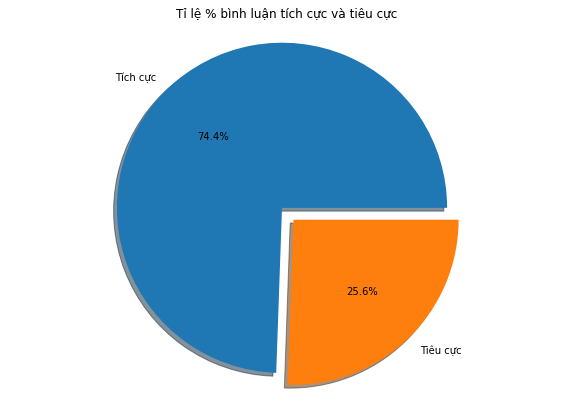

In [50]:
#Tính % số lượng các loại comment
num_trust_cmt = df['is_trust'].value_counts()[1]
num_not_trust_cmt = df['is_trust'].value_counts()[0]

trust_ratio = ((num_trust_cmt / df.shape[0])*100).round(2);
not_trust_ratio = ((num_not_trust_cmt / df.shape[0])*100).round(2);
not_trust_ratio

data = [trust_ratio,not_trust_ratio]
labels = ['Tích cực', "Tiêu cực"]

fig = plt.figure(figsize =(10, 7)) 
plt.pie(data, labels = labels, explode = (0.1, 0), autopct='%1.1f%%',shadow=True) 
plt.title('Tỉ lệ % bình luận tích cực và tiêu cực')
plt.axis('equal')
# show plot 
plt.show() 


In [10]:
#code here

# 2. Predict

## Lấy dữ liệu comment từ  URL

In [11]:
#code here

## Xử lý dữ liệu

In [12]:
#code here
def processing_data(data):
    # 1. Standardize data
    data_frame = pd.DataFrame(data)
    print('data frame:', data_frame)
    data_frame[0] = data_frame[0].apply(standardize_data)

    # 2. Tokenizer
    data_frame[0] = data_frame[0].apply(tokenizer)

    # 3. Embedding
    X_val = data_frame[0]
    return X_val

## Load Pre-train model BERT

In [13]:
def load_pretrainModel(data):
    '''
    Load pretrain model/ tokenizers
    Return : features
    '''
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    #encode lines
    tokenized = data.apply((lambda x: tokenizer.encode(x, add_special_tokens = True,max_length=512,truncation=True)))

    # get lenght max of tokenized
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    print('max len:', max_len)

    # if lenght of tokenized not equal max_len , so padding value 0
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    print('padded:', padded[1])
    print('len padded:', padded.shape)

    #get attention mask ( 0: not has word, 1: has word)
    attention_mask = np.where(padded ==0, 0,1)
    print('attention mask:', attention_mask[1])

    # Convert input to tensor
    padded = torch.tensor(padded,dtype=torch.long)
    attention_mask = torch.tensor(attention_mask)


    # Load model
    with torch.no_grad():
        last_hidden_states = model(padded, attention_mask =attention_mask)
    #     print('last hidden states:', last_hidden_states)

    features = last_hidden_states[0][:,0,:].numpy()
    print('features:', features)
    
    return features


## Predict

In [14]:
def predict(url):
    # 1. Load URL and print comments
    if url== "":
        url = "https://tiki.vn/dien-thoai-samsung-galaxy-m31-128gb-6gb-hang-chinh-hang-p58259141.html"
    data = load_url_selenium_lazada(url)
#     data = load_url_selenium_tiki(url)
    data = processing_data(data)
    features = load_pretrainModel(data)
    # 2. Load weights
    model = joblib.load('save_model.pkl')
    # 3. Result
    result = model.predict(features)
    print(result)
    print(analyze(result))
# predict(url ='https://tiki.vn/dien-thoai-samsung-galaxy-s20-plus-hang-chinh-hang-p48886153.html?src=search&2hi=0&keyword=s20&src=mega-menu')
predict(url = 'https://www.lazada.vn/products/iphone-8-plus-chinh-hang-vna-moi-100-chua-kich-hoat-chua-qua-su-dung-bao-hanh-12-thang-tai-ttbh-apple-tra-gop-lai-suat-0-qua-the-tin-dung-man-hinh-retina-hd-55-inch-3d-touch-chip-a11-ios11-i757986604-s1985088475.html?spm=a2o4n.searchlistcategory.list.4.46d0bdd5OzWEVE&search=1')

NameError: name 'load_url_selenium_lazada' is not defined